In [1]:
import datetime
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import random
%matplotlib inline

print(f'MPS avaiable: {torch.backends.mps.is_available()}, build with: {torch.backends.mps.is_built()}')

device = 'mps' if torch.backends.mps.is_available() else \
  'cuda' if torch.backends.cuda.is_available() else \
  'cpu'

device = 'cpu'
print(f'Device: {device}')
print(f'Torch version: {torch.__version__}')
random.seed(0)
datafolder = './data/FMNIST'

fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(datafolder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

MPS avaiable: True, build with: True
Device: cpu
Torch version: 1.13.0


In [2]:
class FMINSTDataset(Dataset):
    def __init__(self, x, y):
        #x = (x.float() -128) / 255
        x = x.float() / 255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
        
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

In [10]:
# possiamo ottenere il model creando una rete ad N livelli sequenziale
# sfruttando nn.Sequential oppure in modo costruttivo diretto derivando
# da nn.Module e vedere in dettaglio cosa avviene su ogni layer
def get_model_direct(learning_rate=1e-3):
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28*28, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, 10)
        ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, learning_rate)
    return model, loss_fn, optimizer


def get_model_by_construction(learning_rate=1e-3):
    class Neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_dropout = nn.Dropout(0.25)
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_dropout = nn.Dropout(0.25)
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        def forward(self, x):
            #x = self.input_to_hidden_dropout(x)
            x = self.input_to_hidden_layer(x)
            #x = self.batch_norm(x)
            x = self.hidden_layer_activation(x)
            #x = self.hidden_to_output_dropout(x)
            x = self.hidden_to_output_layer(x)
            return x
    model = Neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, learning_rate)
    return model, loss_fn, optimizer

#get_model = get_model_direct
get_model = get_model_by_construction


In [9]:
from torch.optim import SGD, Adam

def get_optimizer(model, learning_rate):
    return Adam(model.parameters(), lr=learning_rate)

def l_regularization(model, l_type):
    l_regularization = 0
    l_gamma = l_type == 0.0001 if l_type == 1 else 0.01
    for p in model.parameters():
        l_regularization += torch.norm(p, l_type)
    return l_gamma * l_regularization

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    # all'errore può essere aggiunta una valutazione dei pesi per evitare valori eccessivi degli stessi
    batch_loss = loss_fn(prediction, y) #+ l_regularization(model, 2)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [5]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [6]:
def get_data():
    train = FMINSTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val_data = FMINSTDataset(val_images, val_targets)
    val_dl = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    return trn_dl, val_dl


In [7]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


In [11]:
from torch import optim

N_EPOCHS = 5
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(1e-3)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
opt_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
    factor=0.5, patience=0, threshold=True, min_lr=1e-5, threshold_mode='abs', verbose=True)

t_start = datetime.datetime.now()

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch} []')
    train_epoch_losses, train_epoch_accuracies = [], []
    print('\n\tTraining cicle: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        #print(f'\tTraing cicle: ix  = {ix}')
        #print(f'\tTraing cicle: x   = {x}')
        #print(f'\tTraing cicle: y   = {y}')
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
        #if ix>100: break
    
    train_epoch_loss = np.array(train_epoch_losses).mean()
        
    print('\n\tAccuracy cicle on training data: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        #print(f'\tAccuracy cicle: ix    = {ix}')
        #print(f'\tAccuracy cicle: batch = {batch}')
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        #if ix>100: break
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    print('\n\tAccuracy cicle on validation data: ', end='')
    for ix, batch in enumerate(iter(val_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        opt_scheduler.step(validation_loss)
        
    val_epoch_accuracy = np.mean(val_is_correct)    
    print(f' current accuracy {val_epoch_accuracy}', end='')
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

t_elapsed = datetime.datetime.now() - t_start
print(t_elapsed)

# 32/5 [ADAM] --> 31.2s accuracy >~85%
# 32/5 [SGD]  --> 17.3s accuracy <~85%
# 32/10 [SGD]  --> 35.8s accuracy >~85%
# 32/10 [ADAM]  --> 61.9s accuracy <~85% jumpy!
# 32/5 [ADAM] --> 29.67s accuracy 89% - with lr optimizer
# 32/5 [ADAM] --> 39.26s accuracy 89% - with lr optimizer & batc_norm
# 32/5 [ADAM] --> 41.26s accuracy ~88% - with lr optimizer & batc_norm & dropout
# 32/5 [ADAM] --> 50.80s accuracy ~86% - with lr optimizer & batc_norm & dropout & L1
# 32/5 [ADAM] --> 50.59s accuracy ~87% - with lr optimizer & batc_norm & dropout & L2


Epoch: 0 []

	Training cicle: .........................................................
	Accuracy cicle on training data: .........................................................
	Accuracy cicle on validation data: . current accuracy 0.8537
Epoch: 1 []

	Training cicle: .........................................................
	Accuracy cicle on training data: .........................................................
	Accuracy cicle on validation data: .Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
 current accuracy 0.8582
Epoch: 2 []

	Training cicle: .........................................................
	Accuracy cicle on training data: .........................................................
	Accuracy cicle on validation data: .Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.
 current accuracy 0.8772
Epoch: 3 []

	Training cicle: .........................................................
	Accuracy cicle on training data: ...........................

In [94]:
import platform
print(f'Platform : {platform.platform()}')
print(f'Device   : {device}')
print(f'Torch MPS: {torch.has_mps}')
print(val_losses)
print(val_accuracies)

#[0.8396197241942088, 0.5353731442213059, 0.48255981571276985, 0.45433049147129057, 0.4355701746821404]
#[0.7962333333333333, 0.8300333333333333, 0.8386, 0.8508166666666667, 0.8534833333333334]
model, loss_fn, optimizer = get_model()
trn_dl, val_dl = get_data()
x, y = next(iter(trn_dl))
%timeit train_batch(x, y, model, optimizer, loss_fn)

Platform : macOS-12.6-arm64-arm-64bit
Device   : cpu
Torch MPS: True
[0.42796412110328674, 0.42841866612434387, 0.3964039385318756, 0.3761349022388458, 0.3658756911754608]
[0.8463, 0.8457, 0.8569, 0.8636, 0.8697]
4.67 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


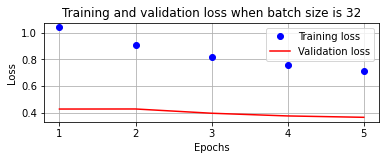

/var/folders/44/sqmxmlfx5k383gls301l5s100000gn/T/ipykernel_48295/3276711084.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks().tolist()])


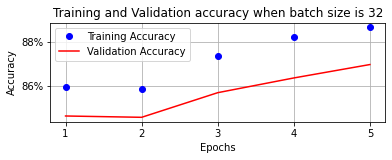

In [95]:
import matplotlib.ticker as mticker

epochs = np.arange(len(train_losses)) + 1

plt.subplot(211)
plt.title('Training and validation loss when batch size is 32')
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.title('Training and Validation accuracy when batch size is 32')
plt.plot(epochs, train_accuracies, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('off')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks().tolist()])
plt.legend()
plt.grid('off')
plt.show()

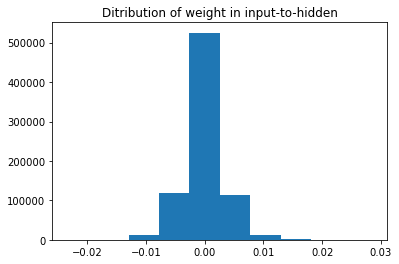

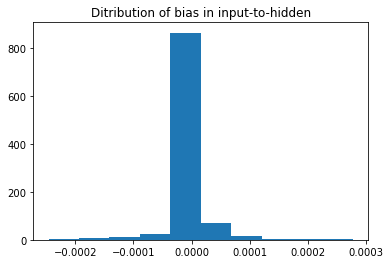

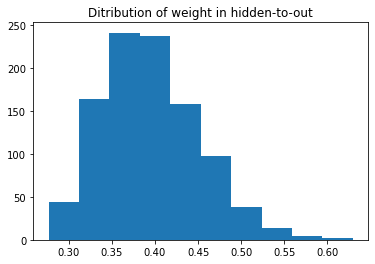

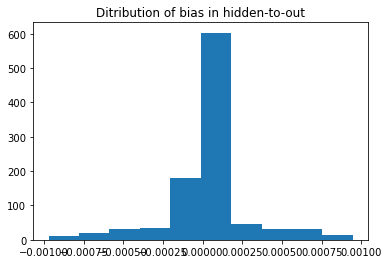

In [96]:
#Plot pmodel parameters distribution

for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Ditribution of weight in input-to-hidden')
        plt.show()
    if(ix==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Ditribution of bias in input-to-hidden')
        plt.show()
    if(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Ditribution of weight in hidden-to-out')
        plt.show()
    if(ix==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Ditribution of bias in hidden-to-out')
        plt.show()
        

In [27]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


/opt/anaconda3/envs/p310/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(
